# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [1]:
#Import relevant libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests as re
import os
import datetime as dt
import scipy.stats as st

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize, StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, r2_score, accuracy_score,mean_squared_error, roc_curve, roc_auc_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from xgboost import plot_tree

plt.rcParams["figure.figsize"] = (15,6)

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [2]:
df_flights = pd.read_csv('flights.csv')

In [3]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110000 entries, 0 to 109999
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   fl_date              110000 non-null  object 
 1   mkt_unique_carrier   110000 non-null  object 
 2   branded_code_share   110000 non-null  object 
 3   mkt_carrier          110000 non-null  object 
 4   mkt_carrier_fl_num   110000 non-null  int64  
 5   op_unique_carrier    110000 non-null  object 
 6   tail_num             109635 non-null  object 
 7   op_carrier_fl_num    110000 non-null  int64  
 8   origin_airport_id    110000 non-null  int64  
 9   origin               110000 non-null  object 
 10  origin_city_name     110000 non-null  object 
 11  dest_airport_id      110000 non-null  int64  
 12  dest                 110000 non-null  object 
 13  dest_city_name       110000 non-null  object 
 14  crs_dep_time         110000 non-null  int64  
 15  dep_time         

In [4]:
pd.isnull(df_flights).sum()

fl_date                     0
mkt_unique_carrier          0
branded_code_share          0
mkt_carrier                 0
mkt_carrier_fl_num          0
op_unique_carrier           0
tail_num                  365
op_carrier_fl_num           0
origin_airport_id           0
origin                      0
origin_city_name            0
dest_airport_id             0
dest                        0
dest_city_name              0
crs_dep_time                0
dep_time                 1249
dep_delay                1249
taxi_out                 1693
wheels_off               1693
wheels_on                1720
taxi_in                  1720
crs_arr_time                0
arr_time                 1321
arr_delay                1541
cancelled                   0
cancellation_code      108700
diverted                    0
dup                         0
crs_elapsed_time            0
actual_elapsed_time      1541
air_time                 1939
flights                     0
distance                    0
carrier_de

#### Variable Descriptions

### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

##### Dropping irrelevant values values

In [5]:
df_flights = df_flights.drop(['flights','cancelled','cancellation_code','dup','diverted','dest_city_name','tail_num',
                 'dep_delay','carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay',
                 'first_dep_time','total_add_gtime','longest_add_gtime','no_name'],axis=1)
df_flights

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,...,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time,distance
0,2018-10-10,AS,AS,AS,1,AS,1,11278,DCA,"Washington, DC",...,809.0,1003.0,10.0,1100,1013.0,-47.0,360,321.0,294.0,2329
1,2018-11-11,G4,G4,G4,2,G4,2,12889,LAS,"Las Vegas, NV",...,1515.0,1600.0,4.0,1619,1604.0,-15.0,71,68.0,45.0,259
2,2019-05-26,G4,G4,G4,2,G4,2,12889,LAS,"Las Vegas, NV",...,5.0,533.0,4.0,600,537.0,-23.0,245,227.0,208.0,1510
3,2019-06-12,WN,WN,WN,4,WN,4,11259,DAL,"Dallas, TX",...,850.0,925.0,3.0,935,928.0,-7.0,60,55.0,35.0,189
4,2018-05-03,DL,DL,DL,5,DL,5,12892,LAX,"Los Angeles, CA",...,2105.0,2154.0,4.0,2216,2158.0,-18.0,76,62.0,49.0,236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109995,2019-12-05,DL,DL,DL,716,DL,716,10397,ATL,"Atlanta, GA",...,2250.0,2327.0,4.0,2359,2331.0,-28.0,137,117.0,97.0,689
109996,2018-10-26,WN,WN,WN,716,WN,716,11066,CMH,"Columbus, OH",...,1242.0,1449.0,4.0,1500,1453.0,-7.0,145,140.0,127.0,930
109997,2018-10-28,DL,DL,DL,716,DL,716,13487,MSP,"Minneapolis, MN",...,1751.0,1915.0,5.0,1947,1920.0,-27.0,242,220.0,204.0,1522
109998,2019-03-03,B6,B6,B6,716,B6,716,12451,JAX,"Jacksonville, FL",...,1905.0,2027.0,4.0,1824,2031.0,127.0,108,96.0,82.0,634


In [6]:
#We will drop NAN columns since it doesnt have a significant impact on a dataset of 110,000
print("Old length of dataset with NAN values:",len(df_flights))
df_flights = df_flights.dropna()

Old length of dataset with NAN values: 110000


In [7]:
print(pd.isnull(df_flights).sum())
print("New length of dataset after dropping NAN values:",len(df_flights))

fl_date                0
mkt_unique_carrier     0
branded_code_share     0
mkt_carrier            0
mkt_carrier_fl_num     0
op_unique_carrier      0
op_carrier_fl_num      0
origin_airport_id      0
origin                 0
origin_city_name       0
dest_airport_id        0
dest                   0
crs_dep_time           0
dep_time               0
taxi_out               0
wheels_off             0
wheels_on              0
taxi_in                0
crs_arr_time           0
arr_time               0
arr_delay              0
crs_elapsed_time       0
actual_elapsed_time    0
air_time               0
distance               0
dtype: int64
New length of dataset after dropping NAN values: 108061


In [8]:
df_flights.dtypes

fl_date                 object
mkt_unique_carrier      object
branded_code_share      object
mkt_carrier             object
mkt_carrier_fl_num       int64
op_unique_carrier       object
op_carrier_fl_num        int64
origin_airport_id        int64
origin                  object
origin_city_name        object
dest_airport_id          int64
dest                    object
crs_dep_time             int64
dep_time               float64
taxi_out               float64
wheels_off             float64
wheels_on              float64
taxi_in                float64
crs_arr_time             int64
arr_time               float64
arr_delay              float64
crs_elapsed_time         int64
actual_elapsed_time    float64
air_time               float64
distance                 int64
dtype: object

In [9]:
#Weather column will be avoided do to api strain on 110,000 rows.

In [10]:
#Statistics
df_flights['arr_delay'].describe().reset_index()

,index,arr_delay
0,count,108061.000000
1,mean,4.830133
2,std,46.739236
3,min,-84.000000
4,25%,-15.000000
5,50%,-6.000000
6,75%,8.000000
7,max,1402.000000


In [11]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

label_encoder = LabelEncoder()
encode_cols = ['mkt_unique_carrier','origin','dest']
for col in encode_cols:
    df_flights[col] = label_encoder.fit_transform(df_flights[col])

In [12]:
#Delete unique carrier duplicate information.
df_flights = df_flights.drop(['branded_code_share','mkt_carrier','op_unique_carrier'],axis=1)
df_flights.dtypes

fl_date                 object
mkt_unique_carrier       int64
mkt_carrier_fl_num       int64
op_carrier_fl_num        int64
origin_airport_id        int64
origin                   int64
origin_city_name        object
dest_airport_id          int64
dest                     int64
crs_dep_time             int64
dep_time               float64
taxi_out               float64
wheels_off             float64
wheels_on              float64
taxi_in                float64
crs_arr_time             int64
arr_time               float64
arr_delay              float64
crs_elapsed_time         int64
actual_elapsed_time    float64
air_time               float64
distance                 int64
dtype: object

In [13]:
#Convert date to unix timestamp
df_flights['unix_date'] = (pd.to_datetime(df_flights['fl_date'],format='%Y-%m-%d') - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
df_flights[['fl_date','unix_date']].head()

,fl_date,unix_date
0,2018-10-10,1539129600
1,2018-11-11,1541894400
2,2019-05-26,1558828800
3,2019-06-12,1560297600
4,2018-05-03,1525305600


In [14]:
#Airport Traffic, feature inclusion
df_passengers = pd.read_csv('passengers.csv')
df_passengers = df_passengers.groupby(['origin_airport_id'])[['passengers']].agg('sum')
df_passengers = df_passengers.sort_values(by=['passengers'],ascending=False).reset_index()
df_passengers.head(10)

,origin_airport_id,passengers
0,13930,7580294
1,11292,7285747
2,10397,6779152
3,12266,5465448
4,12892,5080153
5,13487,4848615
6,11433,4735339
7,12478,4282239
8,14107,4281457
9,11618,4280150


In [15]:
df_passengers['mean'] = df_passengers['passengers']/df_passengers['passengers'].mean()
df_passengers.head(10)

,origin_airport_id,passengers,mean
0,13930,7580294,27.240010
1,11292,7285747,26.181546
2,10397,6779152,24.361082
3,12266,5465448,19.640248
4,12892,5080153,18.255679
5,13487,4848615,17.423641
6,11433,4735339,17.016580
7,12478,4282239,15.388352
8,14107,4281457,15.385542
9,11618,4280150,15.380845


In [16]:
df_flights = pd.merge(df_flights,df_passengers,how = "left", on = "origin_airport_id").dropna()
#df_flights = pd.concat([df_flights, mrkt_df], axis=1, verify_integrity=True).dropna()

In [17]:
df_flights.head(3)

,fl_date,mkt_unique_carrier,mkt_carrier_fl_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,crs_dep_time,...,crs_arr_time,arr_time,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time,distance,unix_date,passengers,mean
0,2018-10-10,1,1,1,11278,54,"Washington, DC",14747,200,800,...,1100,1013.0,-47.0,360,321.0,294.0,2329,1539129600,1670421.0,6.002707
1,2018-11-11,5,2,2,12889,116,"Las Vegas, NV",11638,70,1508,...,1619,1604.0,-15.0,71,68.0,45.0,259,1541894400,4247530.0,15.263624
2,2019-05-26,5,2,2,12889,116,"Las Vegas, NV",10408,12,2355,...,600,537.0,-23.0,245,227.0,208.0,1510,1558828800,4247530.0,15.263624


In [18]:
#Convert datetime to hour, month and day 
df_flights['datetime'] = pd.to_datetime(df_flights.fl_date)
df_flights['day'] = df_flights['datetime'].dt.day
df_flights['month'] = df_flights['datetime'].dt.month
df_flights['year'] = df_flights['datetime'].dt.year

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

<AxesSubplot:>

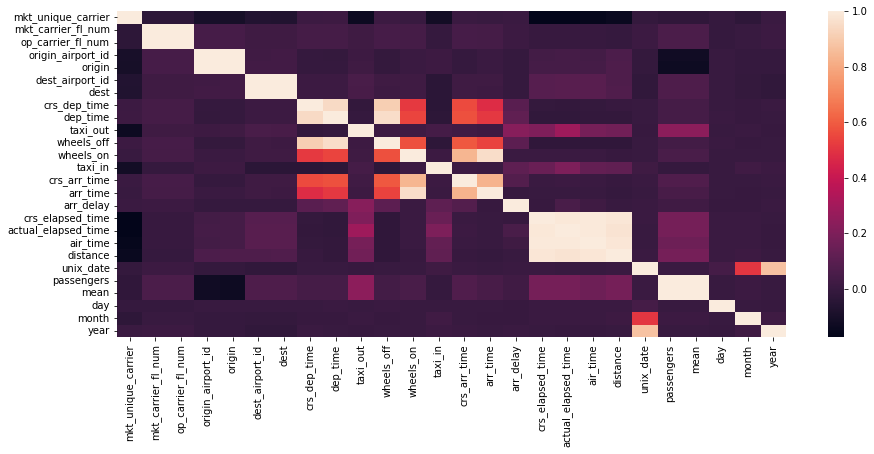

In [19]:
#Feature Selection
#Checking for correlatiobn between features.
sns.heatmap(df_flights.corr())

In [20]:
#Feature Selection
#Univariate Selection for better indication of which features to use.
#Statistical tests can be used to select those features that have the strongest relationship with the output variable.

X = df_flights.drop(['arr_delay','fl_date','origin_city_name','datetime'],axis=1)  #independent columns
y = df_flights['arr_delay']   #target column i.e price range

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

               Specs         Score
20        passengers  1.347744e+09
19         unix_date  1.361190e+08
18          distance  2.546102e+06
8           dep_time  8.634091e+05
10        wheels_off  8.534938e+05
7       crs_dep_time  5.360602e+05
11         wheels_on  4.335217e+05
13      crs_arr_time  4.302145e+05
14          arr_time  4.020535e+05
15  crs_elapsed_time  3.034180e+05


In [70]:
#Features for good LG score
X = df_flights[['passengers','unix_date','distance','dep_time','wheels_off','crs_dep_time','wheels_on','crs_arr_time','arr_time','crs_elapsed_time']]
y = df_flights['arr_delay']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=200)

In [24]:
print(X_train.shape)

(75637, 7)


In [25]:
print(y_train.shape)

(75637,)


In [26]:
X_train[0:5]

,unix_date,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,distance
44628,1535328000,12892,14831,1220,1335,75,308
76605,1575072000,14107,14057,1320,1509,169,1009
21145,1571184000,14107,14869,1235,1515,100,507
68002,1564012800,14869,11292,2120,2252,92,391
64841,1533945600,14679,11292,852,1215,143,853


In [27]:
#PCA Components
demo_df = df_flights[['origin_airport_id','dest_airport_id','crs_dep_time','wheels_off','crs_arr_time','distance','unix_date','mean','mkt_unique_carrier','day','month','year','arr_delay']]

In [28]:
#Scale Data
ss = StandardScaler()
scaled_df = ss.fit_transform(demo_df)

In [29]:
#Scaling PCA Componenent
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_df)
components = pca.components_

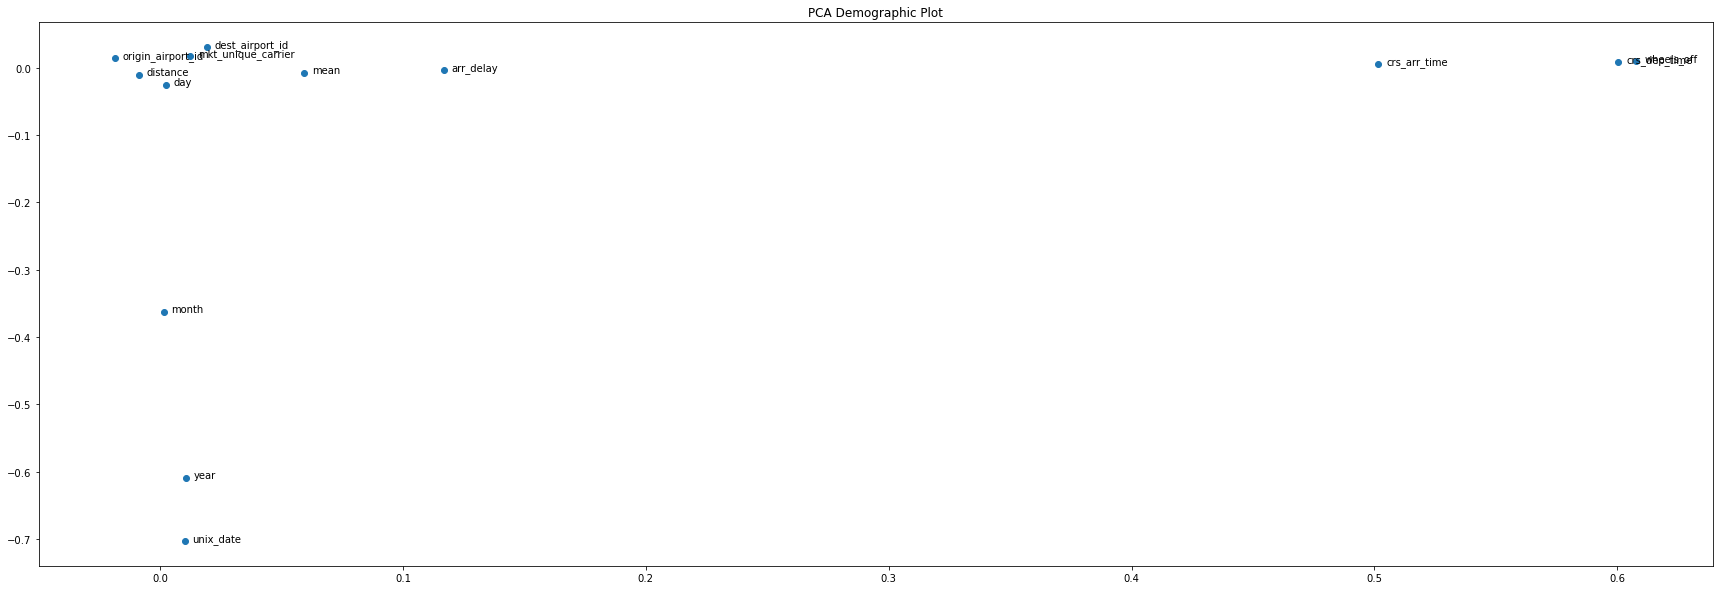

In [30]:
#PCA Scatter Plot
plt.rcParams["figure.figsize"] = (30,10)
fig, ax = plt.subplots(1,1)
ax.set_title("PCA Demographic Plot")
ax.scatter(components[0], components[1])

for i, txt in enumerate(demo_df.columns.to_list()):
    ax.annotate(txt, (components[0][i], components[1][i]), xytext=(8,0), textcoords='offset points')
    
fig.savefig('PCA_components')

### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

### Multinomial logistic regression

In [31]:
#Multinomial logistic regression
LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [32]:
y_pred = LogReg.predict(X_test)

Feature: 0, Score: -0.0000000073
Feature: 1, Score: -0.0000000000
Feature: 2, Score: -0.0000000000
Feature: 3, Score: -0.0000000000
Feature: 4, Score: -0.0000000000
Feature: 5, Score: -0.0000000000
Feature: 6, Score: -0.0000000000


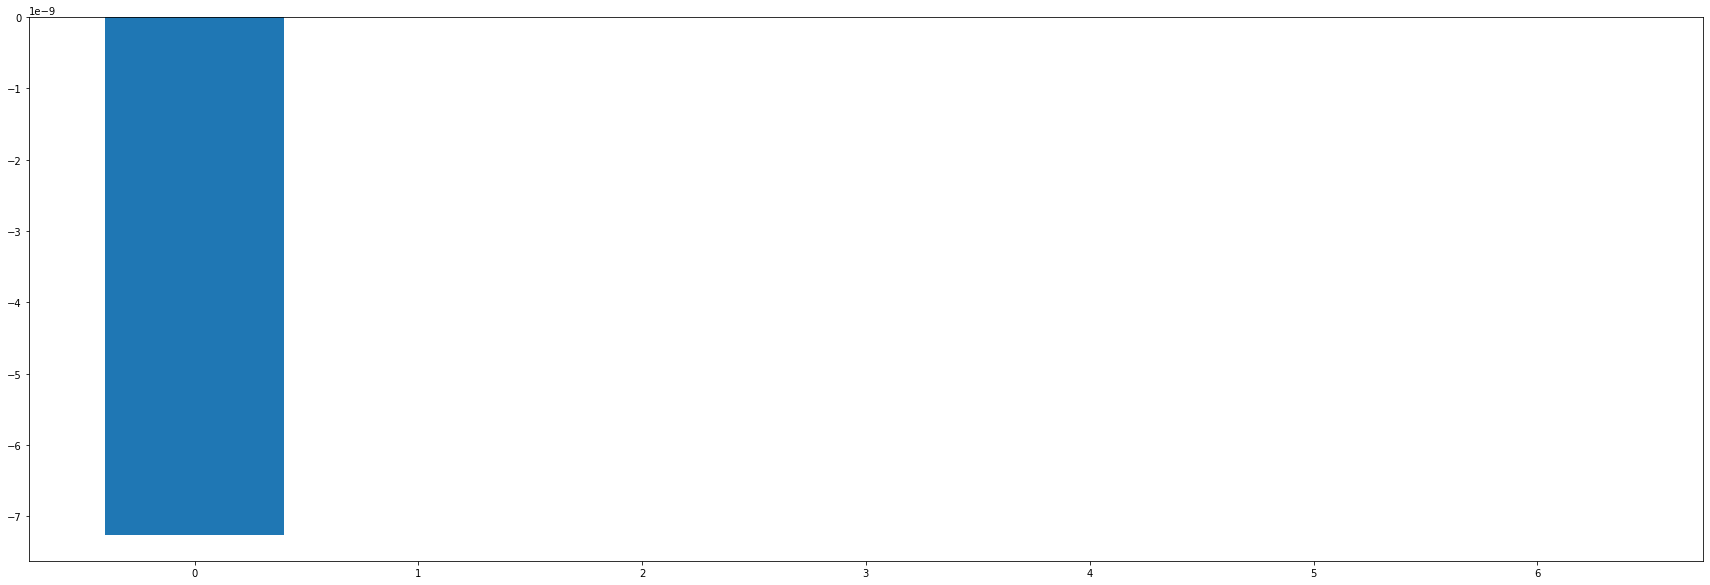

In [33]:
# get importance
importance = LogReg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.10f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

##### Print Classification Report if required

In [34]:
#print(classification_report(y_test, y_pred))

In [35]:
r2_score(y_test,y_pred)

-0.10519415772068741

### Random Forest

In [51]:
X_rf = df_flights[['passengers','unix_date','distance','dep_time','wheels_off','crs_dep_time','wheels_on','crs_arr_time','arr_time','crs_elapsed_time']]
y_rf = df_flights['arr_delay']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_rf,y_rf,test_size=0.3,random_state=200)

In [36]:
# instantiate the classifier 
rfc = RandomForestClassifier(random_state=0)

# fit the model
rfc.fit(X_train, y_train)

# Predict the Test set results
y_pred = rfc.predict(X_test)

In [37]:
# Check accuracy score 
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.0216


In [38]:
# instantiate the classifier with n_estimators = 20
rfc_20 = RandomForestClassifier(n_estimators=20, random_state=0)

# fit the model to the training set
rfc_20.fit(X_train, y_train)

# Predict on the test set results
y_pred_20 = rfc_20.predict(X_test)

In [39]:
# Check accuracy score 
print('Model accuracy score with 20 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_20)))

Model accuracy score with 20 decision-trees : 0.0217


In [40]:
# View the feature scores
feature_scores = pd.Series(rfc_20.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_scores

unix_date            0.366878
crs_arr_time         0.146374
crs_dep_time         0.131204
crs_elapsed_time     0.126381
distance             0.083802
dest_airport_id      0.072693
origin_airport_id    0.072668
dtype: float64

##### Print Classification Report if required

In [41]:
#print(classification_report(y_test, y_pred))

In [42]:
r2_score(y_test,y_pred)

-0.8539690042452053

### Naive Bayes

In [62]:
X_nb = df_flights[['passengers','unix_date','distance','dep_time','wheels_off','crs_dep_time','wheels_on','crs_arr_time','arr_time','crs_elapsed_time']]
y_nb = df_flights['arr_delay']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_nb,y_nb,test_size=0.3,random_state=200)

In [64]:
#Inititate Classifier
clf = GaussianNB()

In [65]:
#Train the model using the training set
clf.fit(X_train,y_train)

GaussianNB()

In [66]:
#Predict the response on the testing data set
y_pred = clf.predict(X_test)

In [67]:
accuracy_score(y_test, y_pred, normalize=True)

0.027147087857847977

In [68]:
r2_score(y_test,y_pred)

-1.7536624611776737

##### Print Classification Report if required

In [69]:
#print(classification_report(y_test, y_pred))

### SVM

In [70]:
X_svm = df_flights[['passengers','unix_date','distance','dep_time','wheels_off','crs_dep_time','wheels_on','crs_arr_time','arr_time','crs_elapsed_time']]
y_svm = df_flights['arr_delay']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_svm,y_svm,test_size=0.3,random_state=200)

In [72]:
#Import SVC 
clf = svm.SVC(kernel='poly')

In [73]:
#Fit training data
clf.fit(X_train, y_train)

SVC(kernel='poly')

In [74]:
#Predict the test data set.
y_pred = clf.predict(X_test)

In [75]:
#Accuracy Score
accuracy_score(y_test, y_pred)

0.02810340572556762

In [76]:
r2_score(y_test,y_pred)

-0.09158271694405329

##### Print Classification Report if required

In [108]:
#print(classification_report(y_test, y_pred))

### XGBoost

In [77]:
X_xgb = df_flights[['passengers','unix_date','distance','dep_time','wheels_off','crs_dep_time','wheels_on','crs_arr_time','arr_time','crs_elapsed_time']]
y_xgb = df_flights['arr_delay']

In [78]:
data_dmatrix = xgb.DMatrix(data=X_xgb,label=y_xgb)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_xgb,y_xgb,test_size=0.3,random_state=200)

In [54]:
#Inititate Regressor
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [55]:
#Fit model
xg_reg.fit(X_train,y_train)

[09:13:20] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643226991592/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=10, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [56]:
#Predict the test data set.
preds = xg_reg.predict(X_test)

In [57]:
#Mean squared error
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 45.747583


In [58]:
r2_score(y_test,preds)

0.01358223798405822

<AxesSubplot:>

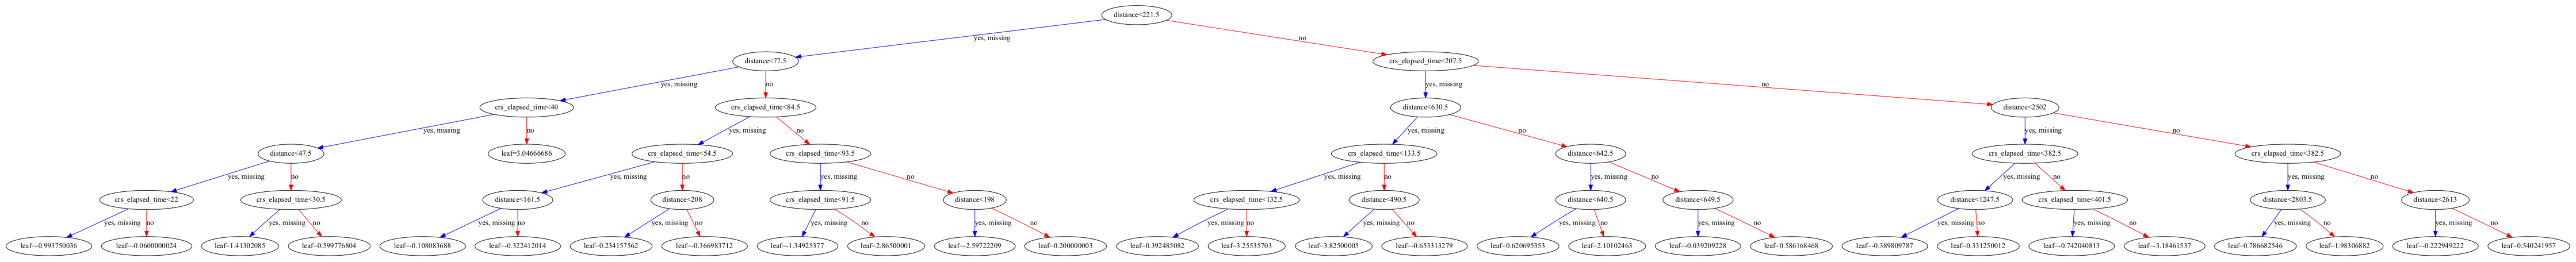

In [59]:
#Plot Tree
plt.rcParams['figure.figsize'] = [80, 10]
plot_tree(xg_reg,num_trees=0)

### Gradient Boosting

In [110]:
X_gb = df_flights[['passengers','unix_date','distance','dep_time','wheels_off','crs_dep_time','wheels_on','crs_arr_time','arr_time','crs_elapsed_time']]
y_gb = df_flights['arr_delay']

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X_gb,y_gb,test_size=0.3,random_state=200)

In [114]:
#Inititate classifier
clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=1, random_state=1)

In [115]:
#Fit the model
clf.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=1, n_estimators=10,
                           random_state=1)

In [116]:
#Predict Model
y_pred = clf.predict(X_test)

In [117]:
#Accuracy Score
accuracy_score(y_test, y_pred)

0.002282823297137216

In [118]:
#R2 Score
r2_score(y_test,y_pred)

-46.81612966103848

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

In [60]:
df_fl_test = pd.read_csv('flights_test_V2.csv')
df_fl_test.head(1)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance
0,1577854800000,WN,WN,WN,5888,WN,N951WN,5888,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1810,1945,N,95,1,363


In [61]:
test = df_fl_test[['fl_date','mkt_carrier_fl_num','op_carrier_fl_num','origin_airport_id','dest_airport_id','crs_dep_time','crs_arr_time','crs_elapsed_time','flights','distance']]

In [62]:
test = test.to_numpy()

In [63]:
#Random Forest Model
y_pred = xg_reg.predict(test)

In [64]:
#[['passengers','unix_date','distance','dep_time','wheels_off','crs_dep_time','wheels_on','crs_arr_time','arr_time','crs_elapsed_time']]

In [65]:
df_fl_test['predicted_delay']=pd.Series(y_pred)

In [66]:
df_fl_test.head(20)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance,predicted_delay
0,1577854800000,WN,WN,WN,5888,WN,N951WN,5888,13891,ONT,...,14771,SFO,"San Francisco, CA",1810,1945,N,95,1,363,5.023643
1,1577854800000,WN,WN,WN,6276,WN,N467WN,6276,13891,ONT,...,14771,SFO,"San Francisco, CA",1150,1320,N,90,1,363,3.320382
2,1577854800000,WN,WN,WN,4598,WN,N7885A,4598,13891,ONT,...,14831,SJC,"San Jose, CA",2020,2130,N,70,1,333,4.695590
3,1577854800000,WN,WN,WN,4761,WN,N551WN,4761,13891,ONT,...,14831,SJC,"San Jose, CA",1340,1455,N,75,1,333,3.181036
4,1577854800000,WN,WN,WN,5162,WN,N968WN,5162,13891,ONT,...,14831,SJC,"San Jose, CA",915,1035,N,80,1,333,1.068086
5,1577854800000,WN,WN,WN,5684,WN,N7856A,5684,13891,ONT,...,14831,SJC,"San Jose, CA",600,715,N,75,1,333,0.580550
6,1577854800000,WN,WN,WN,6152,WN,N7735A,6152,13891,ONT,...,14831,SJC,"San Jose, CA",1620,1740,N,80,1,333,4.306197
7,1577854800000,WN,WN,WN,1679,WN,N405WN,1679,13891,ONT,...,14893,SMF,"Sacramento, CA",1505,1630,N,85,1,390,4.306197
8,1577854800000,WN,WN,WN,3479,WN,N489WN,3479,13891,ONT,...,14893,SMF,"Sacramento, CA",1230,1355,N,85,1,390,3.544401
9,1577854800000,WN,WN,WN,4069,WN,N7708E,4069,13891,ONT,...,14893,SMF,"Sacramento, CA",740,900,N,80,1,390,0.583641


In [68]:
#Convert fl_date from unix to dattime object
from datetime import datetime
df_fl_test = df_fl_test.rename(columns={"fl_date":"unix_date"})
for i in df_fl_test['unix_date']:
    i = int(float(i))/1000
    df_fl_test['fl_date'] = datetime.utcfromtimestamp(i).strftime('%Y-%m-%d')

In [69]:
final_df = df_fl_test[['fl_date','mkt_carrier','mkt_carrier_fl_num','origin','dest','predicted_delay']]
final_df.to_csv('submission.csv',index=False)

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.